In [22]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [191]:
class nn(object):
    def __init__(self,input, l1, output):
        self.input = input 
        self.l1 = l1
        self.output = output

In [192]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [193]:
def red(u,pesos):
    u = np.dot(u,pesos.input)
    u = sigmoid(u)
    u = np.dot(u,pesos.l1)
    u = sigmoid(u)
    u = np.dot(u,pesos.output)
    u = np.exp(u)/np.exp(u).sum()
    return u.argmax()

In [194]:
def generacion_eval(muestra,pesos):
    l=0
    m=0
    for row in muestra.iterrows():
        u = row[1][row[1].index!='target']
        u = u.values
        u = red(u,pesos)
        if u == row[1].target:
            l+=1
        m+=1
    return float(l)/float(m)

In [195]:
def crear_generacion_inicial(n_input,n_output,n):
    generacion = []
    for i in range(n):
        input = np.random.normal(size=[n_input,n_input])
        l1 = np.random.normal(size=[n_input,n_input])
        output = np.random.normal(size=[n_input,n_output])
        pesos = nn(input,l1,output)
        generacion.append(pesos)
    return generacion

In [196]:
def nueva_generacion(df,n_input,n_output):
    df = df.reset_index(drop=True)
    df = df.loc[0:200]
    generacion = df.individuos.tolist()
    nueva_generacion = []
    
    for individuo in generacion:
        for j in range(3):
            i = np.random.randint(0,3)
            input = individuo.input + 1.0/float(10**i)*np.random.normal(size=[n_input,n_input])
            l1 = individuo.l1 + 1.0/float(10**i)*np.random.normal(size=[n_input,n_input])
            output = individuo.output + 1.0/float(10**i)*np.random.normal(size=[n_input,n_output])
            individuo1 = nn(input,l1,output)
            nueva_generacion.append(individuo1)
        i1 = df.individuos.sample(1).values[0]
        i2 = df.individuos.sample(1).values[0]
        input = i1.input + i2.input
        l1 = i1.l1 + i2.l1
        output = i1.output+i2.output
        individuo4 = nn(input,l1,output)        
        nueva_generacion.append(individuo4)
        nueva_generacion.append(individuo)
    return nueva_generacion
        



In [9]:
titanic = pd.read_csv('train.csv')
titanic = titanic[['Survived','Pclass','Sex','Age','SibSp','Parch']]
titanic['target'] = titanic.Survived
titanic['Pclass_1']=np.where(titanic.Pclass==1,1,0)
titanic['Pclass_2']=np.where(titanic.Pclass==2,1,0)
titanic['Pclass_3']=np.where(titanic.Pclass==3,1,0)
titanic['Sex']=np.where(titanic.Sex=='male',1,0)
titanic = titanic.fillna(titanic.mean())
titanic[['Age']] = titanic[['Age']]/titanic[['Age']].mean()
del titanic['Pclass'],titanic['Survived']
len(titanic)

891

In [20]:
titanic_train = titanic.sample(600)
titanic_test = titanic.loc[~titanic.index.isin(titanic_train.index),:]
x_train = titanic_train[['Sex','Age','SibSp','Parch',
                         'Pclass_1','Pclass_2','Pclass_3']].values
y_train = titanic_train.target.values
x_test = titanic_test[['Sex','Age','SibSp','Parch',
                         'Pclass_1','Pclass_2','Pclass_3']].values
y_test = titanic_test.target.values

In [38]:

model = Sequential()
model.add(Dense(7, input_dim=7, activation='relu'))

#model.add(Dense(7, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=1000,
          batch_size=128)
score = model.evaluate(x_test, y_test, batch_size=128)
score

Epoch 1/1000
600/600 [==============================] - 1s 1ms/step - loss: 0.6135 - acc: 0.6783
Epoch 2/1000
600/600 [==============================] - 0s 54us/step - loss: 0.6065 - acc: 0.6717
Epoch 3/1000
600/600 [==============================] - 0s 80us/step - loss: 0.6020 - acc: 0.6717
Epoch 4/1000
600/600 [==============================] - 0s 114us/step - loss: 0.5985 - acc: 0.6717
Epoch 5/1000
600/600 [==============================] - 0s 50us/step - loss: 0.5951 - acc: 0.6717
Epoch 6/1000
600/600 [==============================] - 0s 49us/step - loss: 0.5924 - acc: 0.6700
Epoch 7/1000
600/600 [==============================] - 0s 50us/step - loss: 0.5896 - acc: 0.6700
Epoch 8/1000
600/600 [==============================] - 0s 47us/step - loss: 0.5871 - acc: 0.6700
Epoch 9/1000
600/600 [==============================] - 0s 46us/step - loss: 0.5846 - acc: 0.6717
Epoch 10/1000
600/600 [==============================] - 0s 49us/step - loss: 0.5823 - acc: 0.6700
Epoch 11/1000
600/6

600/600 [==============================] - 0s 55us/step - loss: 0.4886 - acc: 0.7750
Epoch 84/1000
600/600 [==============================] - 0s 53us/step - loss: 0.4878 - acc: 0.7750
Epoch 85/1000
600/600 [==============================] - 0s 56us/step - loss: 0.4871 - acc: 0.7750
Epoch 86/1000
600/600 [==============================] - 0s 55us/step - loss: 0.4864 - acc: 0.7750
Epoch 87/1000
600/600 [==============================] - 0s 58us/step - loss: 0.4856 - acc: 0.7750
Epoch 88/1000
600/600 [==============================] - 0s 57us/step - loss: 0.4847 - acc: 0.7750
Epoch 89/1000
600/600 [==============================] - 0s 57us/step - loss: 0.4839 - acc: 0.7733
Epoch 90/1000
600/600 [==============================] - 0s 56us/step - loss: 0.4833 - acc: 0.7750
Epoch 91/1000
600/600 [==============================] - 0s 57us/step - loss: 0.4824 - acc: 0.7767
Epoch 92/1000
600/600 [==============================] - 0s 57us/step - loss: 0.4816 - acc: 0.7750
Epoch 93/1000
600/600 [=

600/600 [==============================] - 0s 55us/step - loss: 0.4452 - acc: 0.7950
Epoch 165/1000
600/600 [==============================] - 0s 59us/step - loss: 0.4453 - acc: 0.7933
Epoch 166/1000
600/600 [==============================] - 0s 53us/step - loss: 0.4447 - acc: 0.7950
Epoch 167/1000
600/600 [==============================] - 0s 56us/step - loss: 0.4444 - acc: 0.7967
Epoch 168/1000
600/600 [==============================] - 0s 59us/step - loss: 0.4442 - acc: 0.7950
Epoch 169/1000
600/600 [==============================] - 0s 58us/step - loss: 0.4440 - acc: 0.7950
Epoch 170/1000
600/600 [==============================] - 0s 59us/step - loss: 0.4438 - acc: 0.7967
Epoch 171/1000
600/600 [==============================] - 0s 59us/step - loss: 0.4438 - acc: 0.7950
Epoch 172/1000
600/600 [==============================] - 0s 57us/step - loss: 0.4435 - acc: 0.7950
Epoch 173/1000
600/600 [==============================] - 0s 57us/step - loss: 0.4431 - acc: 0.7967
Epoch 174/1000


600/600 [==============================] - 0s 56us/step - loss: 0.4322 - acc: 0.8017
Epoch 247/1000
600/600 [==============================] - 0s 55us/step - loss: 0.4320 - acc: 0.8000
Epoch 248/1000
600/600 [==============================] - 0s 54us/step - loss: 0.4318 - acc: 0.8000
Epoch 249/1000
600/600 [==============================] - 0s 83us/step - loss: 0.4320 - acc: 0.8000
Epoch 250/1000
600/600 [==============================] - 0s 55us/step - loss: 0.4316 - acc: 0.7983
Epoch 251/1000
600/600 [==============================] - 0s 55us/step - loss: 0.4318 - acc: 0.8000
Epoch 252/1000
600/600 [==============================] - 0s 55us/step - loss: 0.4315 - acc: 0.7983
Epoch 253/1000
600/600 [==============================] - 0s 54us/step - loss: 0.4313 - acc: 0.8000
Epoch 254/1000
600/600 [==============================] - 0s 53us/step - loss: 0.4312 - acc: 0.8000
Epoch 255/1000
600/600 [==============================] - 0s 56us/step - loss: 0.4318 - acc: 0.8000
Epoch 256/1000


600/600 [==============================] - 0s 65us/step - loss: 0.4254 - acc: 0.8050
Epoch 328/1000
600/600 [==============================] - 0s 62us/step - loss: 0.4255 - acc: 0.8050
Epoch 329/1000
600/600 [==============================] - 0s 53us/step - loss: 0.4255 - acc: 0.8050
Epoch 330/1000
600/600 [==============================] - 0s 58us/step - loss: 0.4254 - acc: 0.8050
Epoch 331/1000
600/600 [==============================] - ETA: 0s - loss: 0.4121 - acc: 0.804 - 0s 54us/step - loss: 0.4253 - acc: 0.8033
Epoch 332/1000
600/600 [==============================] - 0s 55us/step - loss: 0.4255 - acc: 0.8050
Epoch 333/1000
600/600 [==============================] - 0s 57us/step - loss: 0.4252 - acc: 0.8033
Epoch 334/1000
600/600 [==============================] - 0s 55us/step - loss: 0.4252 - acc: 0.8017
Epoch 335/1000
600/600 [==============================] - ETA: 0s - loss: 0.4107 - acc: 0.828 - 0s 61us/step - loss: 0.4251 - acc: 0.8067
Epoch 336/1000
600/600 [===============

600/600 [==============================] - 0s 64us/step - loss: 0.4216 - acc: 0.8050
Epoch 408/1000
600/600 [==============================] - 0s 83us/step - loss: 0.4211 - acc: 0.8033
Epoch 409/1000
600/600 [==============================] - 0s 56us/step - loss: 0.4211 - acc: 0.8050
Epoch 410/1000
600/600 [==============================] - 0s 70us/step - loss: 0.4210 - acc: 0.8050
Epoch 411/1000
600/600 [==============================] - 0s 69us/step - loss: 0.4211 - acc: 0.8067
Epoch 412/1000
600/600 [==============================] - 0s 72us/step - loss: 0.4210 - acc: 0.8050
Epoch 413/1000
600/600 [==============================] - 0s 71us/step - loss: 0.4212 - acc: 0.8050
Epoch 414/1000
600/600 [==============================] - 0s 93us/step - loss: 0.4209 - acc: 0.8083
Epoch 415/1000
600/600 [==============================] - 0s 53us/step - loss: 0.4209 - acc: 0.8067
Epoch 416/1000
600/600 [==============================] - 0s 72us/step - loss: 0.4213 - acc: 0.8033
Epoch 417/1000


600/600 [==============================] - 0s 52us/step - loss: 0.4183 - acc: 0.8117
Epoch 489/1000
600/600 [==============================] - 0s 46us/step - loss: 0.4183 - acc: 0.8117
Epoch 490/1000
600/600 [==============================] - ETA: 0s - loss: 0.4294 - acc: 0.835 - 0s 45us/step - loss: 0.4185 - acc: 0.8117
Epoch 491/1000
600/600 [==============================] - 0s 51us/step - loss: 0.4184 - acc: 0.8117
Epoch 492/1000
600/600 [==============================] - 0s 52us/step - loss: 0.4183 - acc: 0.8150
Epoch 493/1000
600/600 [==============================] - 0s 48us/step - loss: 0.4185 - acc: 0.8117
Epoch 494/1000
600/600 [==============================] - 0s 46us/step - loss: 0.4184 - acc: 0.8133
Epoch 495/1000
600/600 [==============================] - 0s 46us/step - loss: 0.4183 - acc: 0.8150
Epoch 496/1000
600/600 [==============================] - 0s 56us/step - loss: 0.4183 - acc: 0.8117
Epoch 497/1000
600/600 [==============================] - 0s 52us/step - loss

600/600 [==============================] - 0s 52us/step - loss: 0.4172 - acc: 0.8150
Epoch 570/1000
600/600 [==============================] - 0s 50us/step - loss: 0.4168 - acc: 0.8150
Epoch 571/1000
600/600 [==============================] - 0s 47us/step - loss: 0.4167 - acc: 0.8150
Epoch 572/1000
600/600 [==============================] - 0s 46us/step - loss: 0.4166 - acc: 0.8150
Epoch 573/1000
600/600 [==============================] - 0s 56us/step - loss: 0.4168 - acc: 0.8150
Epoch 574/1000
600/600 [==============================] - 0s 51us/step - loss: 0.4167 - acc: 0.8150
Epoch 575/1000
600/600 [==============================] - 0s 55us/step - loss: 0.4167 - acc: 0.8150
Epoch 576/1000
600/600 [==============================] - 0s 52us/step - loss: 0.4166 - acc: 0.8167
Epoch 577/1000
600/600 [==============================] - 0s 55us/step - loss: 0.4165 - acc: 0.8150
Epoch 578/1000
600/600 [==============================] - 0s 53us/step - loss: 0.4171 - acc: 0.8150
Epoch 579/1000


600/600 [==============================] - 0s 54us/step - loss: 0.4155 - acc: 0.8150
Epoch 652/1000
600/600 [==============================] - 0s 62us/step - loss: 0.4156 - acc: 0.8150
Epoch 653/1000
600/600 [==============================] - 0s 63us/step - loss: 0.4155 - acc: 0.8150
Epoch 654/1000
600/600 [==============================] - 0s 58us/step - loss: 0.4153 - acc: 0.8167
Epoch 655/1000
600/600 [==============================] - 0s 52us/step - loss: 0.4155 - acc: 0.8150
Epoch 656/1000
600/600 [==============================] - 0s 46us/step - loss: 0.4154 - acc: 0.8167
Epoch 657/1000
600/600 [==============================] - 0s 60us/step - loss: 0.4157 - acc: 0.8150
Epoch 658/1000
600/600 [==============================] - 0s 52us/step - loss: 0.4155 - acc: 0.8150
Epoch 659/1000
600/600 [==============================] - 0s 49us/step - loss: 0.4153 - acc: 0.8150
Epoch 660/1000
600/600 [==============================] - 0s 57us/step - loss: 0.4154 - acc: 0.8150
Epoch 661/1000


600/600 [==============================] - 0s 55us/step - loss: 0.4145 - acc: 0.8167
Epoch 733/1000
600/600 [==============================] - 0s 62us/step - loss: 0.4145 - acc: 0.8150
Epoch 734/1000
600/600 [==============================] - 0s 57us/step - loss: 0.4143 - acc: 0.8150
Epoch 735/1000
600/600 [==============================] - 0s 53us/step - loss: 0.4143 - acc: 0.8150
Epoch 736/1000
600/600 [==============================] - 0s 56us/step - loss: 0.4145 - acc: 0.8150
Epoch 737/1000
600/600 [==============================] - ETA: 0s - loss: 0.3824 - acc: 0.796 - 0s 61us/step - loss: 0.4145 - acc: 0.8150
Epoch 738/1000
600/600 [==============================] - 0s 58us/step - loss: 0.4147 - acc: 0.8133
Epoch 739/1000
600/600 [==============================] - 0s 64us/step - loss: 0.4144 - acc: 0.8150
Epoch 740/1000
600/600 [==============================] - 0s 58us/step - loss: 0.4144 - acc: 0.8150
Epoch 741/1000
600/600 [==============================] - 0s 57us/step - loss

600/600 [==============================] - 0s 57us/step - loss: 0.4136 - acc: 0.8167
Epoch 813/1000
600/600 [==============================] - 0s 56us/step - loss: 0.4134 - acc: 0.8150
Epoch 814/1000
600/600 [==============================] - 0s 51us/step - loss: 0.4137 - acc: 0.8167
Epoch 815/1000
600/600 [==============================] - 0s 48us/step - loss: 0.4135 - acc: 0.8167
Epoch 816/1000
600/600 [==============================] - 0s 52us/step - loss: 0.4134 - acc: 0.8167
Epoch 817/1000
600/600 [==============================] - 0s 58us/step - loss: 0.4133 - acc: 0.8150
Epoch 818/1000
600/600 [==============================] - 0s 50us/step - loss: 0.4135 - acc: 0.8150
Epoch 819/1000
600/600 [==============================] - 0s 48us/step - loss: 0.4132 - acc: 0.8150
Epoch 820/1000
600/600 [==============================] - 0s 47us/step - loss: 0.4134 - acc: 0.8150
Epoch 821/1000
600/600 [==============================] - 0s 49us/step - loss: 0.4132 - acc: 0.8150
Epoch 822/1000


600/600 [==============================] - 0s 49us/step - loss: 0.4125 - acc: 0.8167
Epoch 894/1000
600/600 [==============================] - 0s 46us/step - loss: 0.4125 - acc: 0.8183
Epoch 895/1000
600/600 [==============================] - 0s 46us/step - loss: 0.4126 - acc: 0.8167
Epoch 896/1000
600/600 [==============================] - 0s 51us/step - loss: 0.4125 - acc: 0.8200
Epoch 897/1000
600/600 [==============================] - 0s 61us/step - loss: 0.4126 - acc: 0.8200
Epoch 898/1000
600/600 [==============================] - 0s 47us/step - loss: 0.4124 - acc: 0.8217
Epoch 899/1000
600/600 [==============================] - 0s 50us/step - loss: 0.4125 - acc: 0.8183
Epoch 900/1000
600/600 [==============================] - 0s 59us/step - loss: 0.4122 - acc: 0.8167
Epoch 901/1000
600/600 [==============================] - 0s 51us/step - loss: 0.4128 - acc: 0.8183
Epoch 902/1000
600/600 [==============================] - 0s 50us/step - loss: 0.4125 - acc: 0.8183
Epoch 903/1000


600/600 [==============================] - 0s 49us/step - loss: 0.4119 - acc: 0.8217
Epoch 974/1000
600/600 [==============================] - 0s 64us/step - loss: 0.4118 - acc: 0.8183
Epoch 975/1000
600/600 [==============================] - 0s 59us/step - loss: 0.4120 - acc: 0.8200
Epoch 976/1000
600/600 [==============================] - 0s 50us/step - loss: 0.4122 - acc: 0.8217
Epoch 977/1000
600/600 [==============================] - 0s 60us/step - loss: 0.4118 - acc: 0.8217
Epoch 978/1000
600/600 [==============================] - 0s 56us/step - loss: 0.4118 - acc: 0.8200
Epoch 979/1000
600/600 [==============================] - 0s 65us/step - loss: 0.4115 - acc: 0.8200
Epoch 980/1000
600/600 [==============================] - 0s 67us/step - loss: 0.4118 - acc: 0.8217
Epoch 981/1000
600/600 [==============================] - 0s 56us/step - loss: 0.4116 - acc: 0.8200
Epoch 982/1000
600/600 [==============================] - 0s 61us/step - loss: 0.4117 - acc: 0.8200
Epoch 983/1000


[0.4202766951007122, 0.8350515472110605]

In [36]:
titanic = pd.read_csv('test.csv')
titanic = titanic[['Pclass','Sex','Age','SibSp','Parch']]
titanic['Pclass_1']=np.where(titanic.Pclass==1,1,0)
titanic['Pclass_2']=np.where(titanic.Pclass==2,1,0)
titanic['Pclass_3']=np.where(titanic.Pclass==3,1,0)
titanic['Sex']=np.where(titanic.Sex=='male',1,0)
titanic = titanic.fillna(titanic.mean())
titanic[['Age']] = titanic[['Age']]/titanic[['Age']].mean()
del titanic['Pclass']







In [37]:
resultado = pd.read_csv('test.csv')
resultado['Survived'] = model.predict_classes(titanic)
resultado[['PassengerId','Survived']].to_csv('result.csv',index=False)


In [200]:

medias = []
maximos = []
medias_ = []
maximos_ = []
for i in range(100):
    muestra = titanic_train.sample(50)[['Sex','Age','SibSp','Parch',
                                         'Pclass_1','Pclass_2','Pclass_3','target']]
    v = []
    w = []
    for individuo in generacion:
        u = generacion_eval(muestra,individuo)
        v.append(u)
        w.append(generacion_eval(titanic_test.sample(50),individuo))
    u = [xy for xy in zip(generacion,v)]
    w = [xy for xy in zip(generacion,w)]
    u = pd.DataFrame(u,columns=['individuos','puntuacion'])
    w = pd.DataFrame(w,columns=['individuos','puntuacion'])
    u = u.sort_values('puntuacion',ascending=False)
    w = w.sort_values('puntuacion',ascending=False)
    generacion = nueva_generacion(u,7,2)
    medias.append(u.puntuacion.mean())
    maximos.append(u.puntuacion.max())
    medias_.append(w.puntuacion.mean())
    maximos_.append(w.puntuacion.max())
    print(u.puntuacion.mean(),u.puntuacion.max(),w.puntuacion.mean(),w.puntuacion.max())
    


0.5035599999999999 0.9 0.5034400000000001 0.82
0.5743482587064677 0.86 0.5757014925373134 0.88
0.5696318407960199 0.76 0.5951442786069653 0.92
0.6386467661691542 0.8 0.6102885572139303 0.92
0.6537313432835821 0.88 0.6378308457711441 0.9
0.6403582089552238 0.82 0.6408557213930349 0.88
0.7351044776119403 0.9 0.6797014925373135 0.9
0.7251144278606966 0.86 0.6674626865671641 0.9
0.7682189054726368 0.92 0.672318407960199 0.92
0.6483582089552238 0.76 0.6828457711442786 0.9
0.7378905472636816 0.9 0.6773333333333333 0.94
0.7098905472636816 0.86 0.6879004975124379 0.92
0.7766965174129352 0.92 0.6948059701492537 0.92
0.7280995024875622 0.82 0.6916417910447762 0.9
0.8206766169154228 0.92 0.6910248756218905 0.9
0.7873034825870647 0.9 0.6971343283582089 0.92
0.779721393034826 0.9 0.7043582089552237 0.9
0.7674029850746269 0.9 0.707363184079602 0.94
0.7913034825870647 0.9 0.7104875621890547 0.94
0.7976119402985073 0.9 0.7159402985074628 0.9
0.7449552238805971 0.88 0.7257711442786069 0.92
0.7401990049

In [201]:
resultados = pd.DataFrame(list(zip(medias,maximos,medias_,maximos_)),columns=['m','M','m_','M_'])

Populating the interactive namespace from numpy and matplotlib


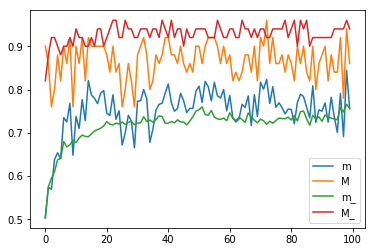

In [202]:
%pylab inline
resultados.plot()